In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import os
os.chdir('/Users/wjl/Documents/GitHub/CreditRiskModelling/')
from scripts.synthetic_data_creation import SyntheticDataCreator
from scripts.feature_engineering import FeatureEngineering
from scripts.model_training import ModelTraining

seed = 23

# Step 1: Synthetic Data Creation

In [2]:
sdc = SyntheticDataCreator()
df = sdc.generate_synthetic_data()


Data saved to /data/synthetic_credit_data.csv


# Step 2: Feature Engineering

In [3]:
# 2.1: Initilizing FeatureEngineering
reference_date = sdc.reference_date
fe = FeatureEngineering(df, reference_date=reference_date)

# 2.2: Derive Features
derived_df = fe.derive_features()

# 2.3: Train/Test Data Split - Optional
train_idx,test_idx=fe.train_test_split()


Feature Derivation Complete.

Features derived are:
Index(['drv_profit_pm_avg_t12m', 'drv_income_pm_avg_t3m',
       'drv_tran_vol_pm_avg_t3m', 'drv_tran_cnt_pm_avg_t3m',
       'drv_profit_margin_rate', 'drv_asset_liability_rate',
       'drv_loan_util_rate', 'drv_inflow_outflow_rate_t3m',
       'drv_addr_cons_flag', 'drv_industry_cons_flag', 'drv_mon_since_apply',
       'drv_mon_since_last_late', 'drv_mon_till_mature',
       'drv_tran_vol_std_t12m', 'drv_inflow_std_t6m',
       'drv_trans_vol_prop_t1t3', 'drv_credit_inquiry_prop_t3t12'],
      dtype='object')
Dropping date columns...

Features dropped are:
['loan_start_date', 'loan_maturity_date', 'loan_last_late_date']


### Logistic Regression

[INFO] filtering variables ...
Variable filtering on 10000 rows and 52 columns in 00:00:30 
31 variables are removed
IV of remaining features are:
                   variable  info_value
18       loan_interest_rate    2.507481
1   drv_tran_cnt_pm_avg_t3m    0.411905
5              tran_cnt_t3m    0.411905
2   loan_utilization_amount    0.213812
4     drv_income_pm_avg_t3m    0.198933
9              credit_score    0.163120
16            business_size    0.140507
8              tran_vol_t1m    0.136369
0           tran_inflow_t3m    0.126660
19         tran_outflow_t3m    0.111073
15               fin_profit    0.080960
12   drv_profit_pm_avg_t12m    0.080960
14             tran_cnt_t1m    0.077806
6               loan_amount    0.057968
10              fin_revenue    0.057614
3              tran_vol_t3m    0.037804
17  drv_tran_vol_pm_avg_t3m    0.037804
7        drv_loan_util_rate    0.025530
11            business_time    0.012610
13       plat_login_cnt_t1m    0.010390
[INFO] creati

/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to r

Plot binning results...


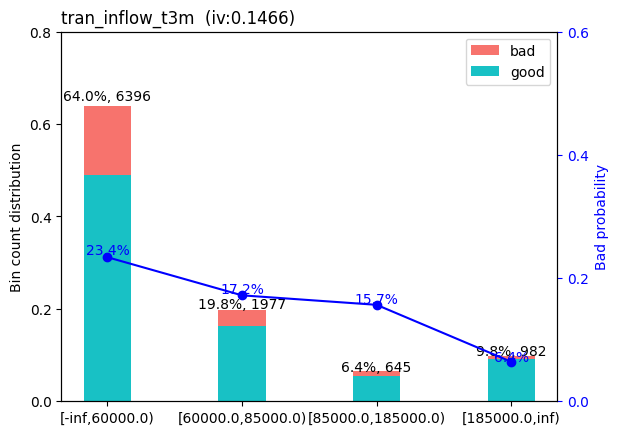

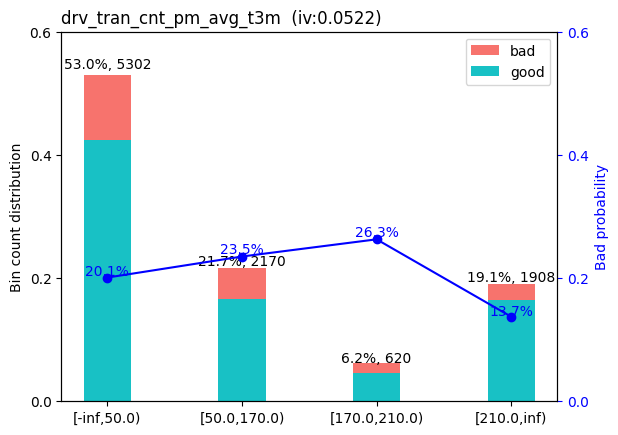

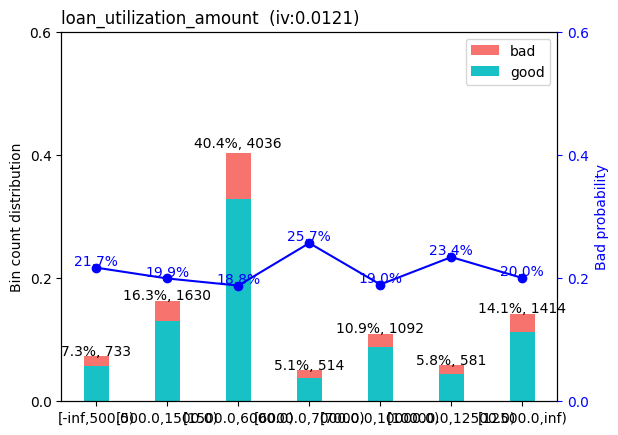

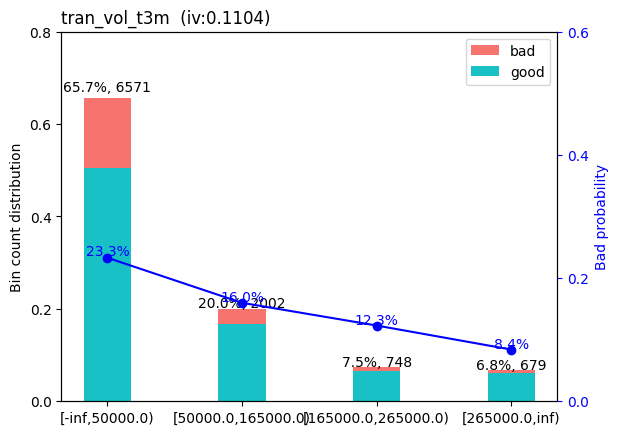

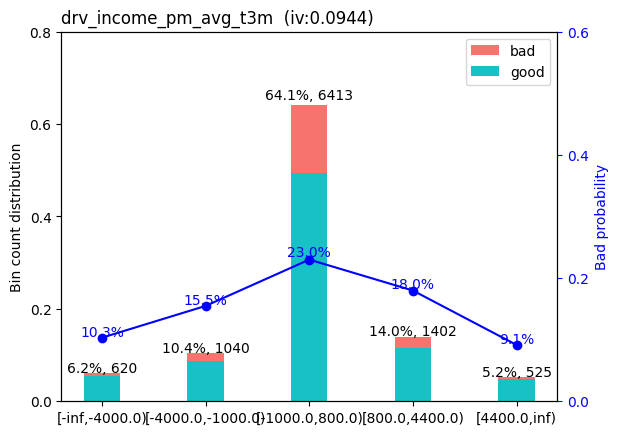

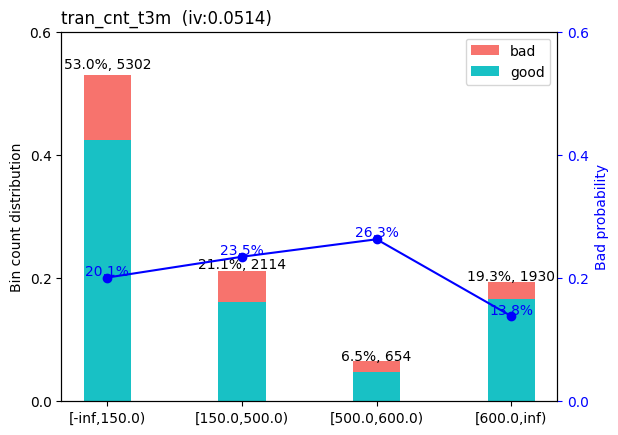

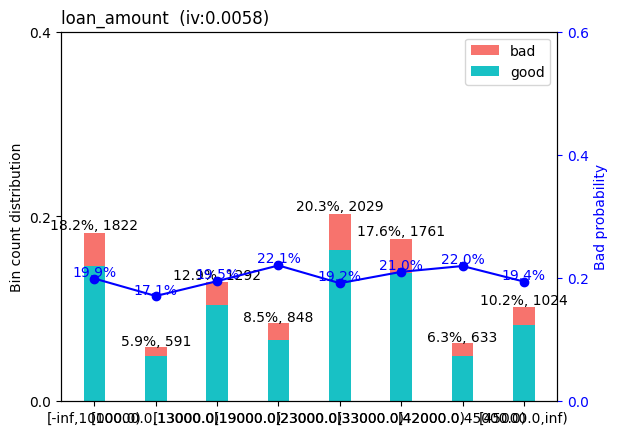

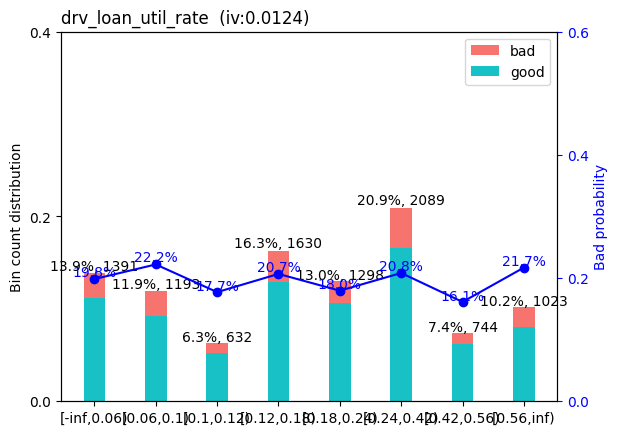

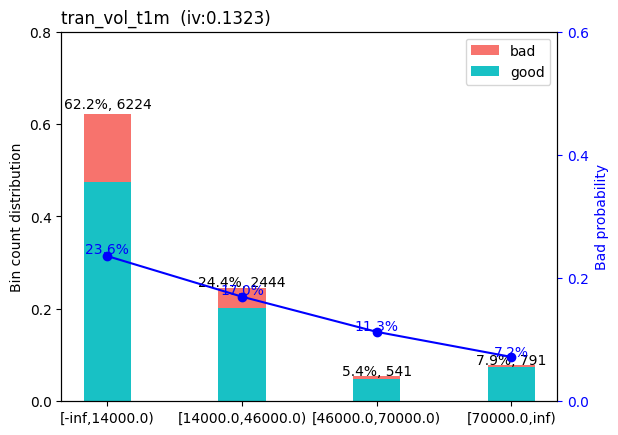

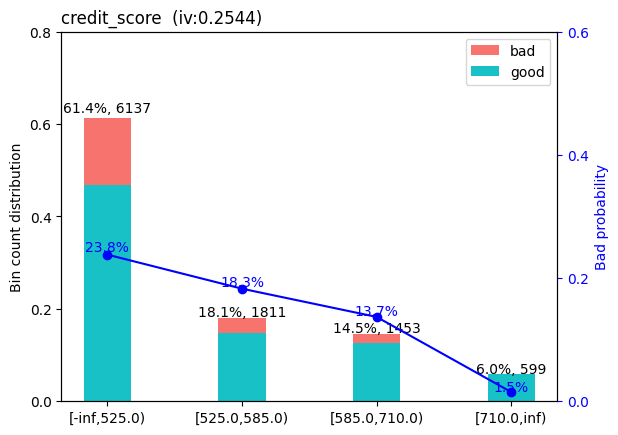

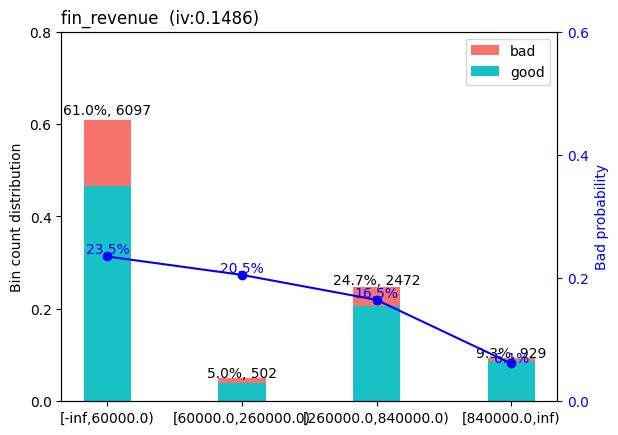

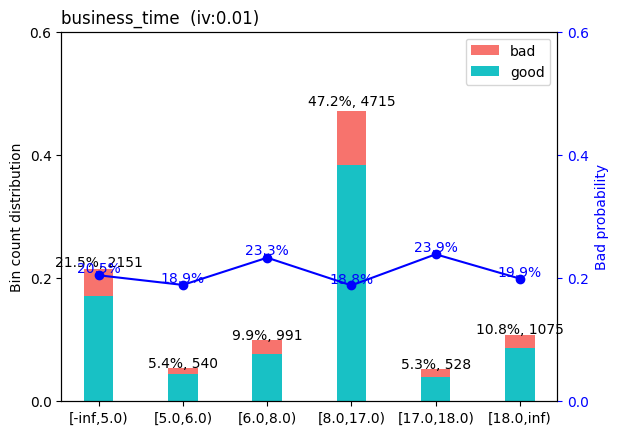

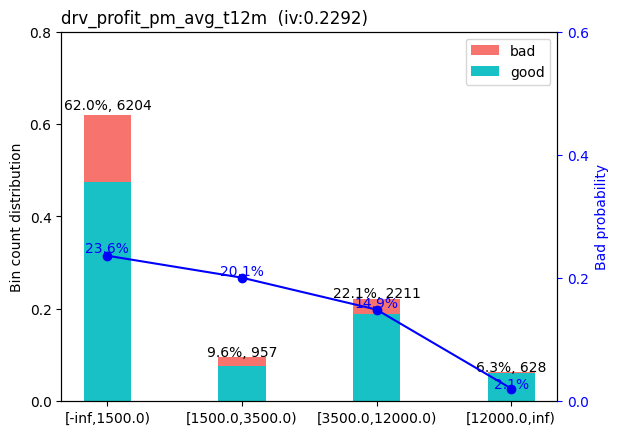

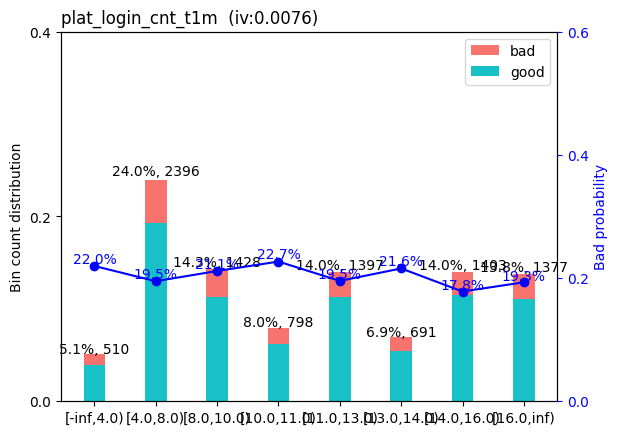

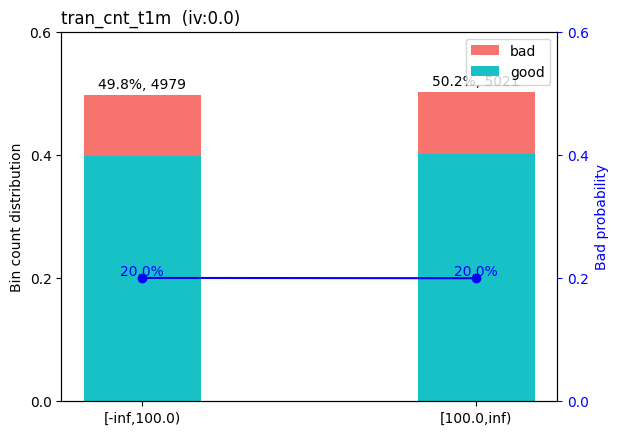

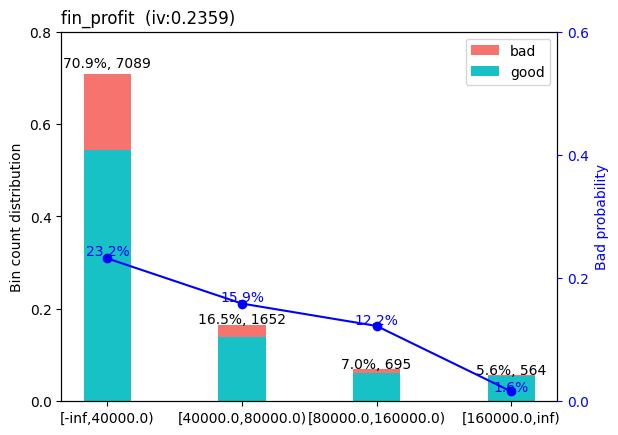

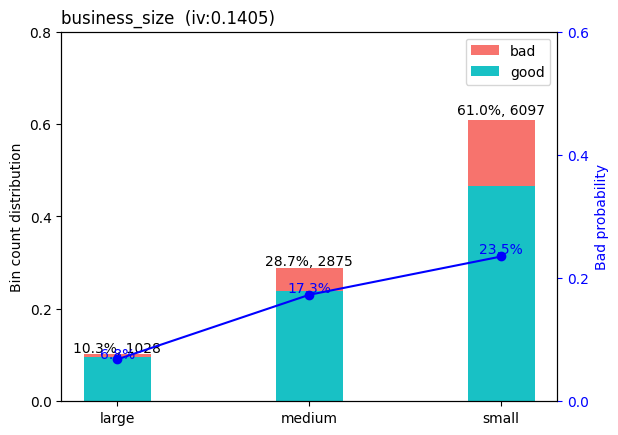

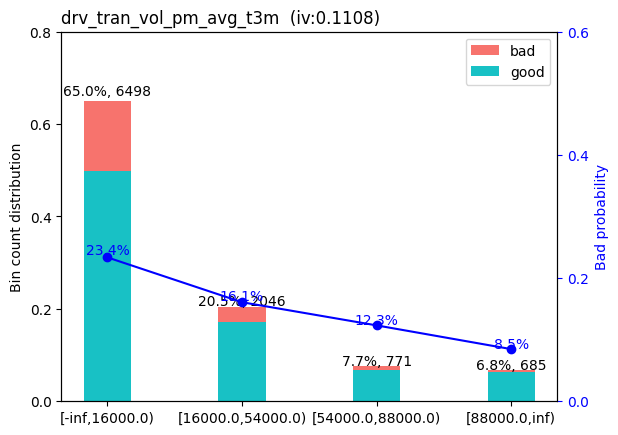

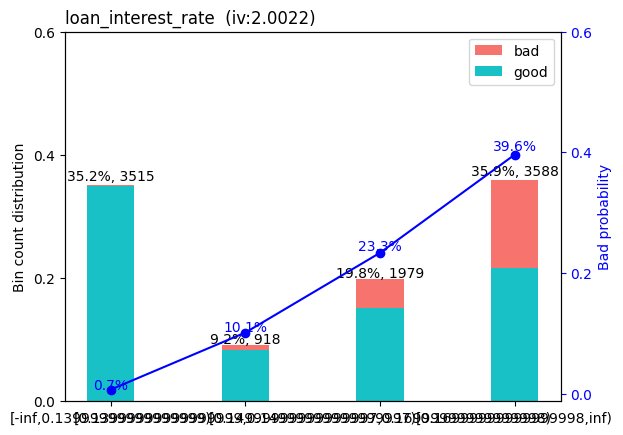

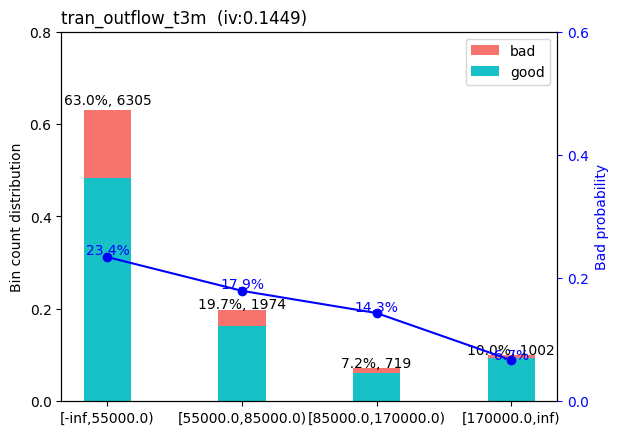

[INFO] creating woe binning ...


/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:160: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['[10000.0,15000.0)', '[

Plot binning results...


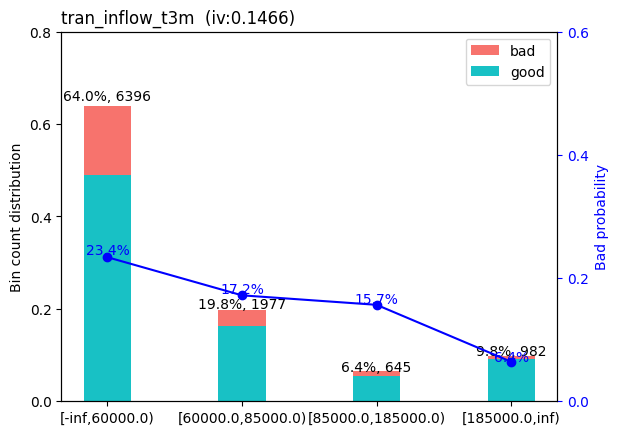

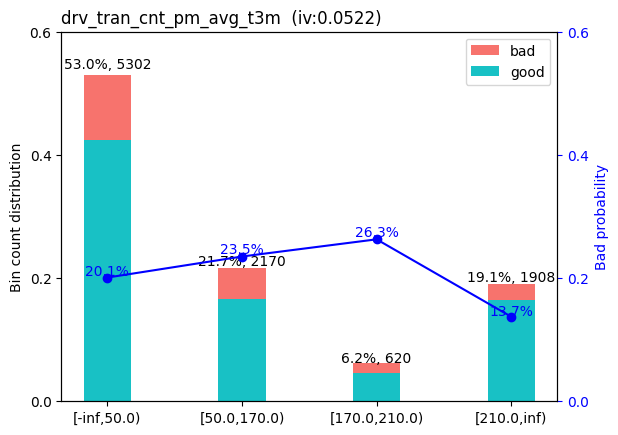

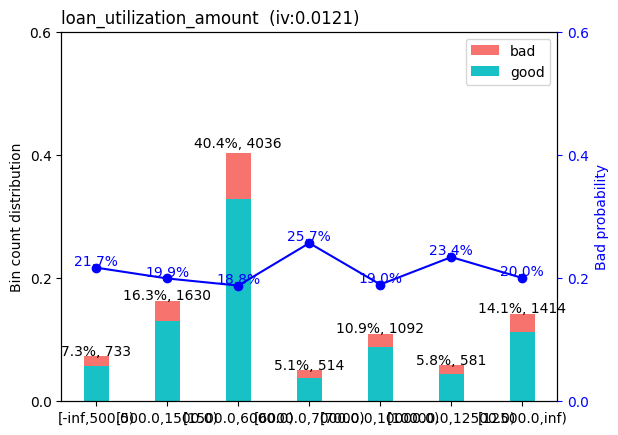

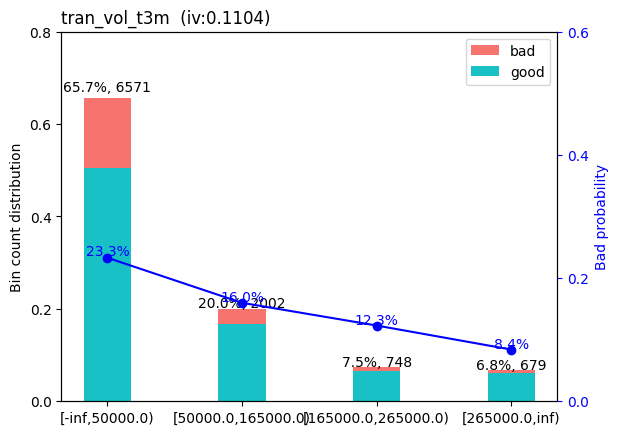

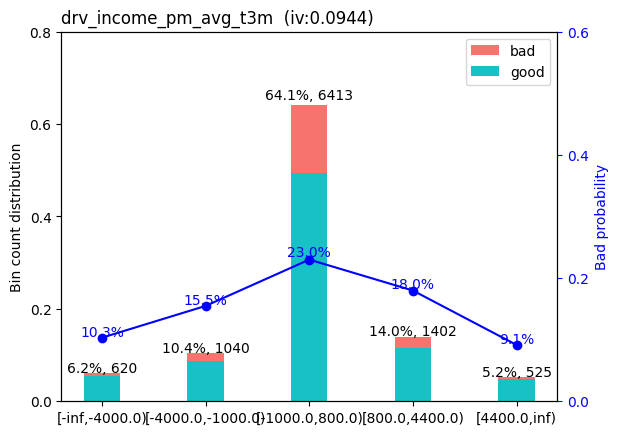

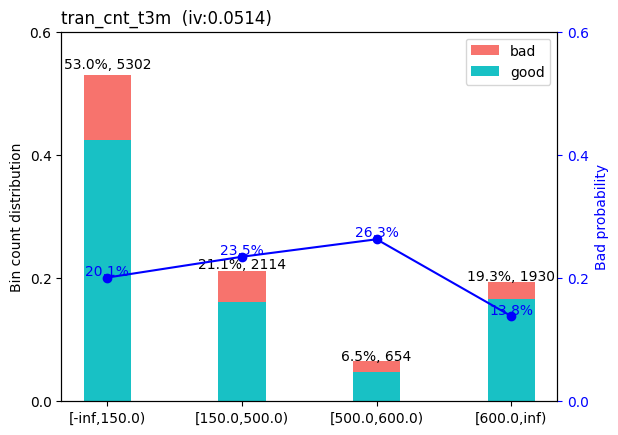

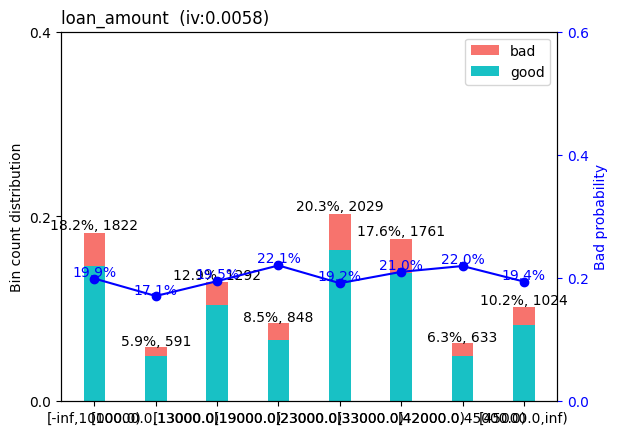

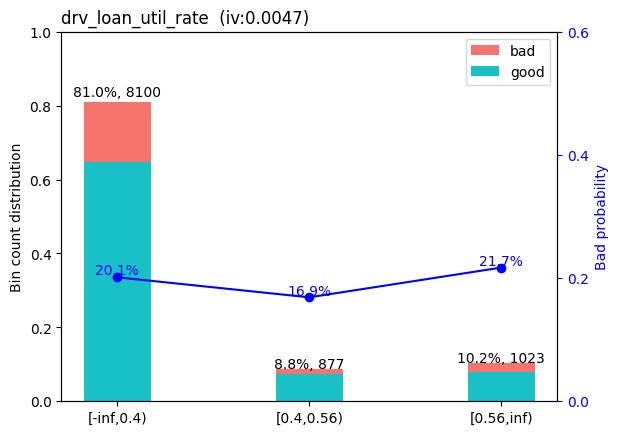

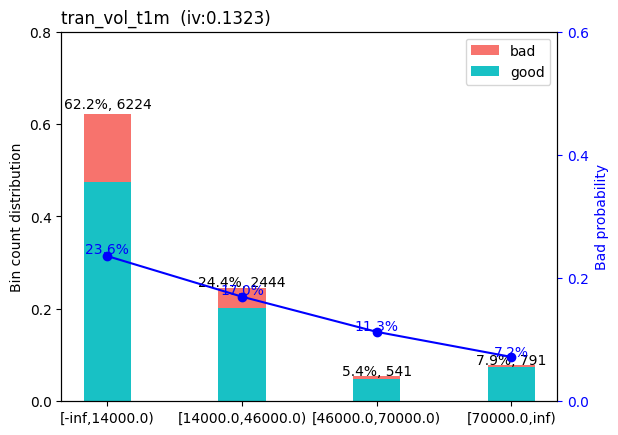

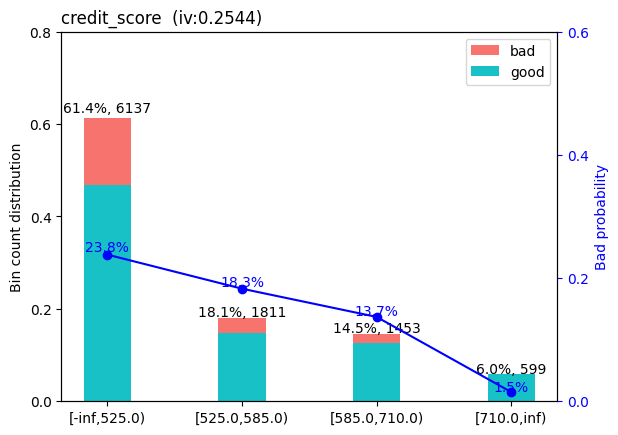

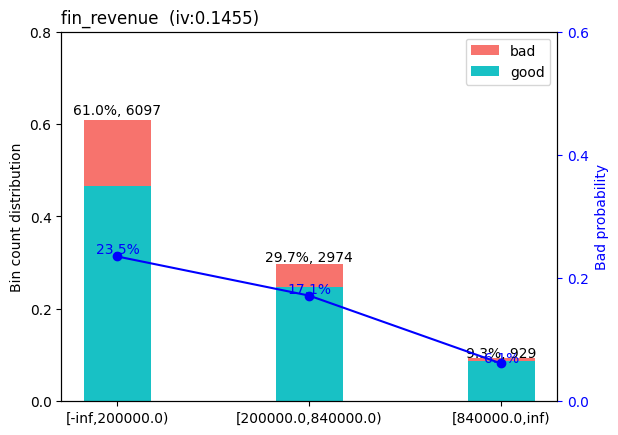

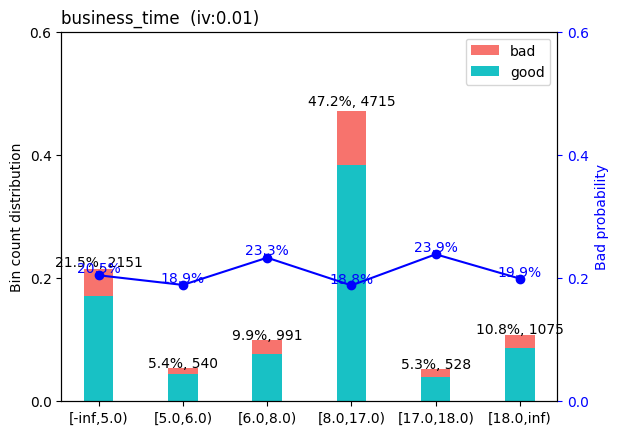

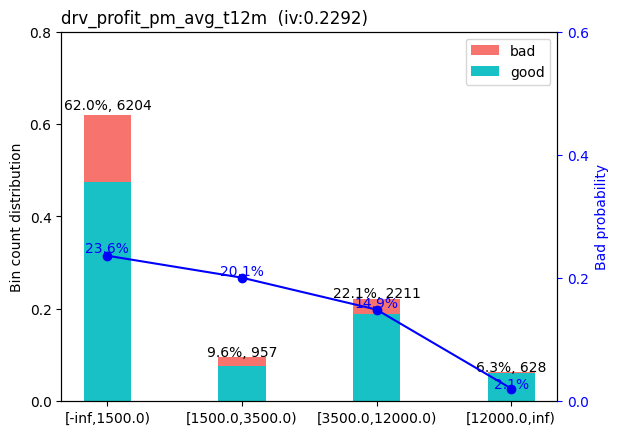

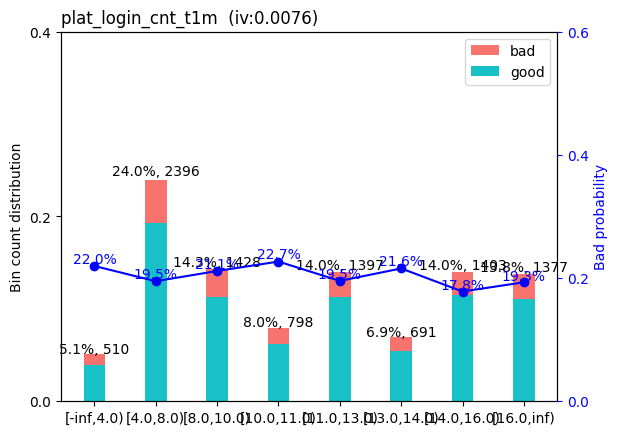

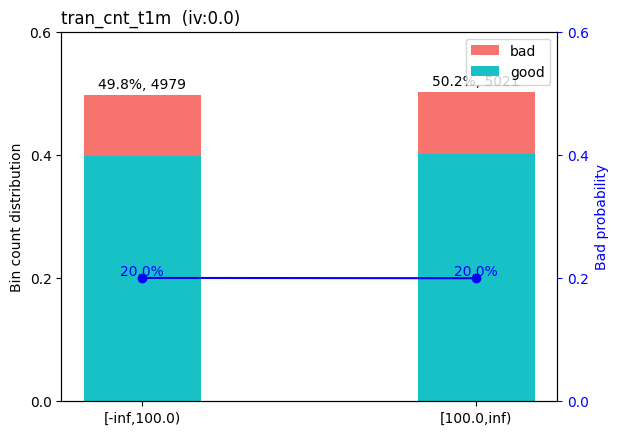

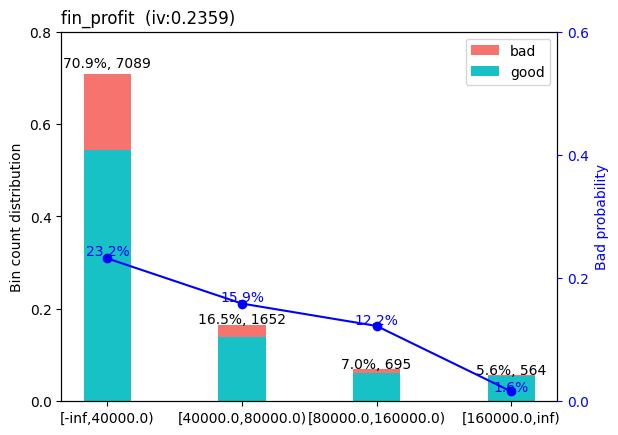

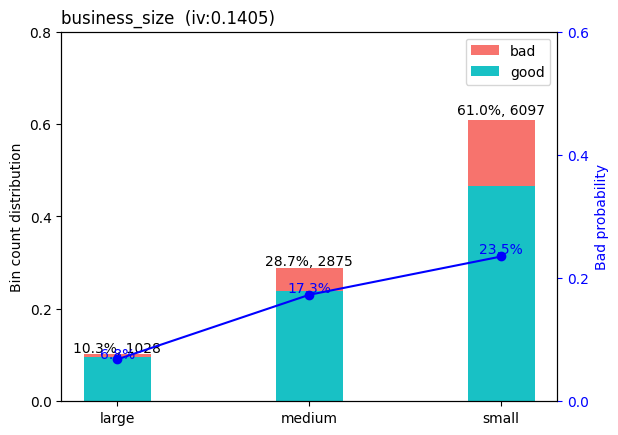

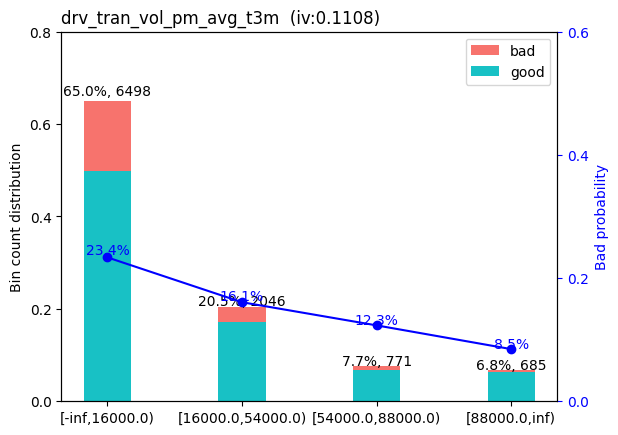

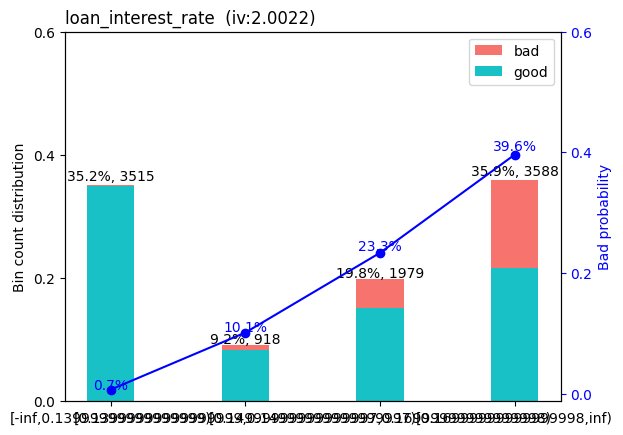

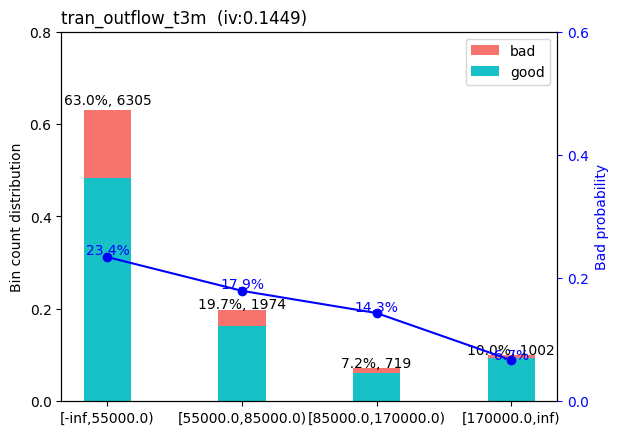

In [11]:
# Step 2.4 Feature Transforming

## Step 2.4.1. Initial Select Features based on IV
selected_features = fe.lr_select_features_iv(var_keep=['plat_login_cnt_t1m','business_time'])

## Step 2.4.2: Transform Features

# WoE Binning
bins = fe.lr_transform_features()

# Adjust WoE Binning - just an example
breaks_adj = {
    'drv_loan_util_rate': [0.4, 0.56],
    'fin_revenue': [200000,840000]
}
bins=fe.lr_transform_features(break_adj=breaks_adj)

In [12]:
# Step 2.5 Select Features - Stepwise Final Selection
result = fe.lr_select_features_stepwise(save_list=['drv_loan_util_rate_woe','plat_login_cnt_t1m_woe'])

[INFO] converting into woe values ...
Add  loan_interest_rate_woe         with p-value 5.44301e-114
Add  tran_outflow_t3m_woe           with p-value 7.19399e-30
Add  credit_score_woe               with p-value 2.89401e-11
Drop tran_outflow_t3m_woe           with p-value 0.280246
Add  loan_utilization_amount_woe    with p-value 0.0185711
Add  fin_profit_woe                 with p-value 0.025009
Add  business_time_woe              with p-value 0.037468
Add  loan_amount_woe                with p-value 0.0412125


### XGBoost Classifier
since there are only 50 features, no actual needs to narrow down the the features, 
but we can still try to see if we can get a better result by using features with higher importance

In [4]:
xdf=fe.xgb_transform_features()
fe.xgb_select_features(40)

Feature Importance of remaining features are:
loan_interest_rate                 0.212491
fin_profit                         0.042528
credit_score                       0.026809
credit_default_cnt_t12m            0.026242
plat_dashboard_cnt_t3m             0.022427
plat_saving_acct_flag              0.021945
tran_cnt_t3m                       0.021731
drv_tran_vol_std_t12m              0.021488
tran_inflow_t3m                    0.021259
tran_outflow_t3m                   0.021012
plat_trsct_acct_flag               0.021010
drv_trans_vol_prop_t1t3            0.020767
tran_vol_t3m                       0.020761
credit_court_cnt_t12m              0.020553
drv_asset_liability_rate           0.020351
fin_revenue                        0.020250
business_location_urban            0.020154
fin_assets                         0.020137
business_review                    0.019978
fin_liabilities                    0.019927
drv_income_pm_avg_t3m              0.019717
plat_login_cnt_t1m            

['business_time',
 'business_job_openings',
 'business_review',
 'plat_customer_support_cnt_t3m',
 'plat_dashboard_cnt_t3m',
 'plat_trsct_acct_flag',
 'plat_saving_acct_flag',
 'plat_login_cnt_t1m',
 'fin_revenue',
 'fin_profit',
 'fin_assets',
 'fin_liabilities',
 'tran_vol_t1m',
 'tran_vol_t3m',
 'tran_cnt_t3m',
 'tran_inflow_t3m',
 'tran_outflow_t3m',
 'credit_score',
 'credit_lines_cnt',
 'credit_current_amt',
 'credit_default_cnt_t12m',
 'credit_inquiry_cnt_t3m',
 'credit_court_cnt_t12m',
 'loan_amount',
 'loan_late_repayment_cnt',
 'loan_interest_rate',
 'loan_utilization_amount',
 'drv_income_pm_avg_t3m',
 'drv_profit_margin_rate',
 'drv_asset_liability_rate',
 'drv_loan_util_rate',
 'drv_inflow_outflow_rate_t3m',
 'drv_tran_vol_std_t12m',
 'drv_inflow_std_t6m',
 'drv_trans_vol_prop_t1t3',
 'business_industry_manufacturing',
 'business_industry_retail',
 'business_industry_services',
 'business_structure_company',
 'business_location_urban',
 'default']

### ANN

In [5]:
adf=fe.ann_transform_features()
fe.ann_select_features(40)

Feature Importance of remaining features are:
loan_interest_rate                 0.215374
fin_profit                         0.039560
credit_score                       0.034335
credit_court_cnt_t12m              0.026675
plat_trsct_acct_flag               0.023700
tran_outflow_t3m                   0.023690
tran_inflow_t3m                    0.022965
drv_tran_vol_std_t12m              0.021223
business_job_openings              0.021215
fin_assets                         0.021148
drv_profit_margin_rate             0.020779
fin_revenue                        0.020186
credit_inquiry_cnt_t12m            0.020122
credit_default_cnt_t12m            0.020022
drv_inflow_std_t6m                 0.019975
plat_customer_support_cnt_t3m      0.019810
credit_inquiry_cnt_t3m             0.019751
tran_cnt_t3m                       0.019600
drv_trans_vol_prop_t1t3            0.019578
drv_asset_liability_rate           0.019288
business_structure_company         0.018885
drv_inflow_outflow_rate_t3m   

['business_time',
 'business_job_openings',
 'plat_customer_support_cnt_t3m',
 'plat_dashboard_cnt_t3m',
 'plat_terminal_flag',
 'plat_trsct_acct_flag',
 'plat_saving_acct_flag',
 'plat_login_cnt_t1m',
 'fin_revenue',
 'fin_profit',
 'fin_assets',
 'fin_liabilities',
 'tran_vol_t1m',
 'tran_vol_t3m',
 'tran_cnt_t3m',
 'tran_inflow_t3m',
 'tran_outflow_t3m',
 'credit_score',
 'credit_lines_cnt',
 'credit_current_amt',
 'credit_default_cnt_t12m',
 'credit_inquiry_cnt_t3m',
 'credit_inquiry_cnt_t12m',
 'credit_court_cnt_t12m',
 'loan_amount',
 'loan_late_repayment_cnt',
 'loan_interest_rate',
 'loan_utilization_amount',
 'drv_income_pm_avg_t3m',
 'drv_profit_margin_rate',
 'drv_asset_liability_rate',
 'drv_loan_util_rate',
 'drv_inflow_outflow_rate_t3m',
 'drv_tran_vol_std_t12m',
 'drv_inflow_std_t6m',
 'drv_trans_vol_prop_t1t3',
 'business_industry_manufacturing',
 'business_industry_services',
 'business_structure_company',
 'business_location_urban',
 'default']

# Step 3 Model trainning

In [6]:
mt = ModelTraining(fe)
mt.train_test_split()

Skipping LR: fe.df_lr has 1 or fewer rows.
Train and test datasets saved to 'data/' directory.


### LR

In [ ]:
# Hyperparameter grid for tuning
param_grid_lr = {
    "penalty": ["l1", "l2","elasticnet"],
    "C": [0.5, 0.6,0.7, 0.9, 1.0],
    "solver": ["liblinear", "saga"],
}
mt.train_lr(param_grid_lr)

Best parameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
Cross-Validation Results:
                                              params  mean_test_score  \
0  {'C': 0.5, 'penalty': 'l1', 'solver': 'libline...         0.821559   
1      {'C': 0.5, 'penalty': 'l1', 'solver': 'saga'}         0.821555   
2  {'C': 0.5, 'penalty': 'l2', 'solver': 'libline...         0.821780   
3      {'C': 0.5, 'penalty': 'l2', 'solver': 'saga'}         0.821772   
4  {'C': 0.5, 'penalty': 'elasticnet', 'solver': ...              NaN   
5  {'C': 0.5, 'penalty': 'elasticnet', 'solver': ...              NaN   
6  {'C': 0.6, 'penalty': 'l1', 'solver': 'libline...         0.821632   
7      {'C': 0.6, 'penalty': 'l1', 'solver': 'saga'}         0.821610   
8  {'C': 0.6, 'penalty': 'l2', 'solver': 'libline...         0.821719   
9      {'C': 0.6, 'penalty': 'l2', 'solver': 'saga'}         0.821720   

   std_test_score  
0        0.009253  
1        0.009249  
2        0.009505  
3        0.009504  
4 

LogisticRegression(C=0.5, max_iter=1000, n_jobs=-1, solver='liblinear')

### XGBoost

In [7]:
# Hyperparameter grid for tuning
param_grid_xgb = {
    "learning_rate": [0.01,0.5, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6,7]
    # ,
    # "min_child_weight": [1, 3,5],
    # "n_estimators": [1000, 2000, 500],
    # 'gamma':[0,1,2,3,4,5],
    # 'subsample':[6,7,8,9,10],
    # 'colsample_bytree':[6,7,8,9,10]
}
mt.train_model(model_type='XGB',params=param_grid_xgb)

Best parameters for XGB: {'learning_rate': 0.01, 'max_depth': 3}
Cross-Validation Results:
                                    params  mean_test_score  std_test_score
0  {'learning_rate': 0.01, 'max_depth': 3}         0.822363        0.009991
1  {'learning_rate': 0.01, 'max_depth': 4}         0.821092        0.010413
2  {'learning_rate': 0.01, 'max_depth': 5}         0.817771        0.008968
3  {'learning_rate': 0.01, 'max_depth': 6}         0.813682        0.007693
4  {'learning_rate': 0.01, 'max_depth': 7}         0.809553        0.004154
5   {'learning_rate': 0.5, 'max_depth': 3}         0.783931        0.010161
6   {'learning_rate': 0.5, 'max_depth': 4}         0.781974        0.008940
7   {'learning_rate': 0.5, 'max_depth': 5}         0.784736        0.007448
8   {'learning_rate': 0.5, 'max_depth': 6}         0.781891        0.008866
9   {'learning_rate': 0.5, 'max_depth': 7}         0.788501        0.010161
Train AUC: 0.831, Test AUC: 0.824
Train KS: 0.538, Test KS: 0.548
XGB mod

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

### ANN

In [8]:
param_grid_ann = {
        "hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "activation": ["relu","sigmoid","tanh"],
        "solver": ["adam","sgd"],
        "alpha": [ 0.0001, 0.001],
        "learning_rate_init": [0.001],
        # "batch_size": [32, 64, 128],
        # "max_iter": [100, 200],
        "early_stopping": [True],
    }
mt.train_model(model_type='ANN',params=param_grid_ann)


Best parameters for ANN: {'activation': 'tanh', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'}
Cross-Validation Results:
                                              params  mean_test_score  \
0  {'activation': 'relu', 'alpha': 0.0001, 'early...         0.802849   
1  {'activation': 'relu', 'alpha': 0.0001, 'early...         0.672512   
2  {'activation': 'relu', 'alpha': 0.0001, 'early...         0.800099   
3  {'activation': 'relu', 'alpha': 0.0001, 'early...         0.685678   
4  {'activation': 'relu', 'alpha': 0.0001, 'early...         0.811951   
5  {'activation': 'relu', 'alpha': 0.0001, 'early...         0.515127   
6  {'activation': 'relu', 'alpha': 0.001, 'early_...         0.802853   
7  {'activation': 'relu', 'alpha': 0.001, 'early_...         0.672511   
8  {'activation': 'relu', 'alpha': 0.001, 'early_...         0.800141   
9  {'activation': 'relu', 'alpha': 0.001, 'early_...         0.685677   

   st

MLPClassifier(activation='tanh', alpha=0.001, early_stopping=True,
              random_state=42)

## Ploting Evaluations

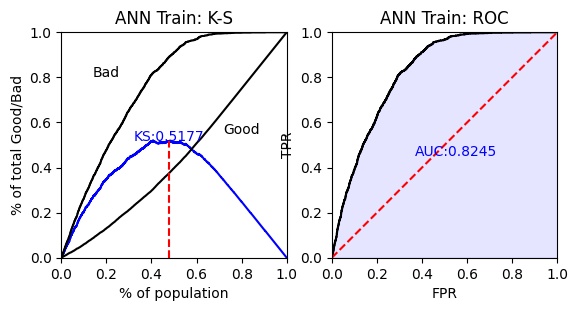

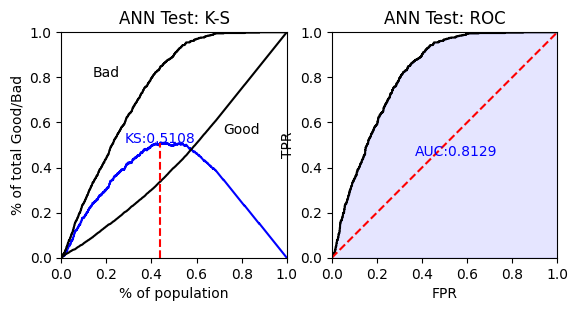

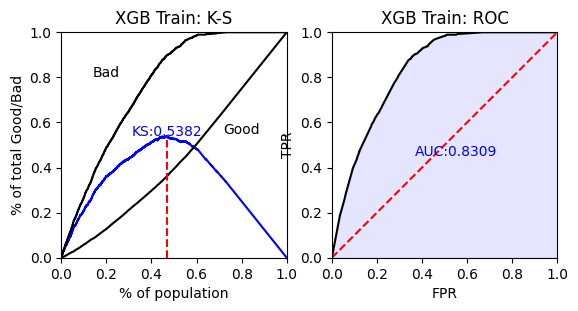

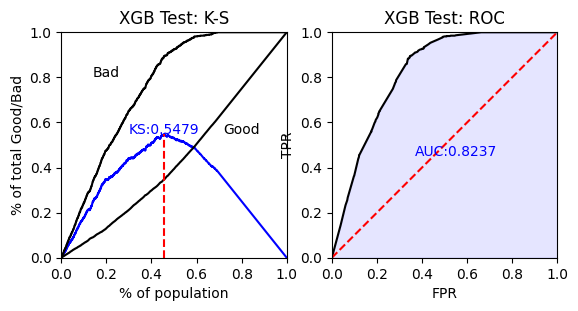

In [9]:
mt.plot_performance_evaluation(models=["ANN", "XGB"])

In [10]:
mt.plot_feature_importance(models=["ANN", "XGB"])

Feature importance plot saved to 'models/ann_Permutation Importance.png'.
Feature importance plot saved to 'models/xgb_Feature Importance.png'.
